In [1]:
!pip install lifelines scikit-survival openpyxl


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4119 sha256=2a43f3ab8c5fad89e254e9557843207a590aacc2e1e163f4db38b55af8090a43
  Stored in directory: /home/codespace/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13/13 [lifelines]13 [lifelines]vival]


In [ ]:
# Adding required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sklearn.preprocessing import LabelEncoder


In [ ]:
# Loading the Excel file using openpyxl engine
df = pd.read_excel("RADCURE_Clinical_v04_20241219.xlsx", engine='openpyxl')

# Preview the dataset
df.head()


,patient_id,Age,Sex,ECOG PS,Smoking PY,Smoking Status,Ds Site,Subsite,T,N,...,Local,Date Local,Regional,Date Regional,Distant,Date Distant,2nd Ca,Date 2nd Ca,RADCURE-challenge,ContrastEnhanced
0,RADCURE-0005,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,post wall,T4b,N2c,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0
1,RADCURE-0006,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,Glottis,T1b,N0,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1
2,RADCURE-0007,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,Tonsil,T3,N2b,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1
3,RADCURE-0009,72.3,Male,ECOG 1,30,Ex-smoker,Unknown,NaN,T0,N2c,...,NaN,NaT,NaN,NaT,NaN,NaT,S (suspicious),2008-05-27,0,0
4,RADCURE-0010,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,Tonsillar Fossa,T4b,N0,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0


In [ ]:
# Extra to check some status

# Check all column names and duplicates
from collections import Counter
counts = Counter(df.columns)
{col: count for col, count in counts.items() if count > 1}


{'Tumor_Stage': 2}

In [ ]:
# Extra to chek
# Drop duplicate columns
df = df.loc[:, ~df.columns.duplicated()]


In [11]:
# Extra - just to check
df['event'].unique()


array([1, 0])

In [ ]:
# Renaming columns
df = df.rename(columns={
    'Length FU': 'survival_time',
    'Status': 'event',
    'Tx Modality': 'Treatment'
})

# Removing duplicate column names, just in case
df = df.loc[:, ~df.columns.duplicated()]

# Removing rows with missing values in required columns
df = df.dropna(subset=['survival_time', 'event', 'Age', 'Treatment', 'Tumor_Stage'])

# Confirming numeric event column
df['event'] = pd.to_numeric(df['event'], errors='coerce').astype(int)

# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder

# Encoding Treatment
df['Treatment'] = LabelEncoder().fit_transform(df['Treatment'])

# Encoding Tumor_Stage
df['Tumor_Stage'] = LabelEncoder().fit_transform(df['Tumor_Stage'])

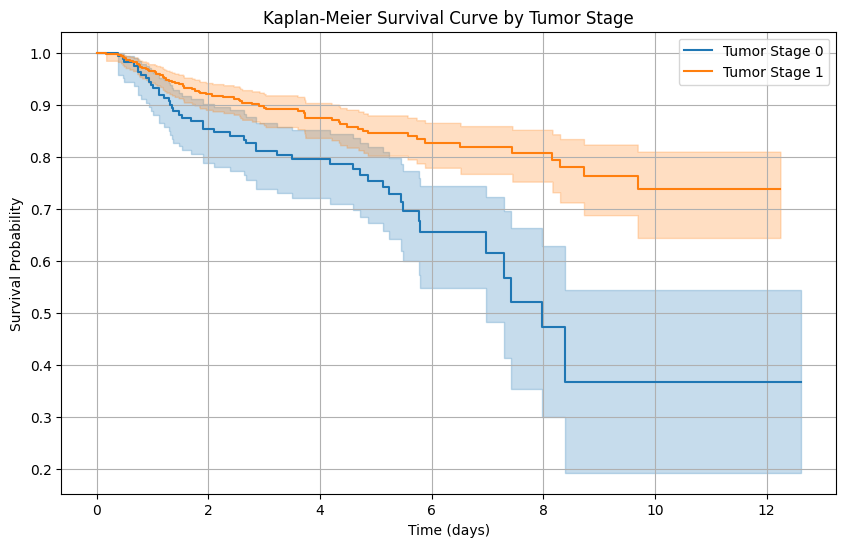

Log-rank test p-value: 2.3998056472670313e-05


In [ ]:
# Kaplan-Meier plot + log-rank test
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Initializing KM fitter
kmf = KaplanMeierFitter()

# ChooseSelecting groups to compare (e.g., Tumor Stage 0 vs 1)
group_0 = df[df['Tumor_Stage'] == 0]
group_1 = df[df['Tumor_Stage'] == 1]

# Visualization - survival curves
plt.figure(figsize=(10, 6))

kmf.fit(group_0['survival_time'], event_observed=group_0['event'], label='Tumor Stage 0')
ax = kmf.plot_survival_function(ci_show=True)

kmf.fit(group_1['survival_time'], event_observed=group_1['event'], label='Tumor Stage 1')
kmf.plot_survival_function(ax=ax, ci_show=True)

plt.title('Kaplan-Meier Survival Curve by Tumor Stage')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

# log-rank test
results = logrank_test(group_0['survival_time'], group_1['survival_time'],
                       event_observed_A=group_0['event'], event_observed_B=group_1['event'])
print("Log-rank test p-value:", results.p_value)


# Explanation of output - Kaplan-Meier Curve

We can distinguish Tumor Stage 0 and 1 sharply; whereas stage 1 is indicating higher life expectancy than stage 0.

The log-rank p-value is < 0.05, therefore, the difference between tumor stage 0 and tumor stage 1 is statistically significant.
Remark: patients with tumor stage 1 had more chance of living than those with tumor stage 0.

In [ ]:
# Cox model
from lifelines import CoxPHFitter

# Selecting relevant columns
cox_data = df[['survival_time', 'event', 'Age', 'Treatment', 'Tumor_Stage']]

# Initializing and fit model
cph = CoxPHFitter()
cph.fit(cox_data, duration_col='survival_time', event_col='event')

# Summary output
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 3318 total observations, 2268 right-censored observations>
             duration col = 'survival_time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3318
number of events observed = 1050
   partial log-likelihood = -7678.16
         time fit was run = 2025-07-10 19:15:49 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Age          0.03      1.03      0.00            0.03            0.04                1.03                1.04
Treatment    0.13      1.14      0.02            0.10            0.17                1.10                1.19
Tumor_Stage  0.11      1.12      0.01            0.09            0.13                1.10                1.13

             cmp to     z      p  -log2(p)
covariate                                 
Age            0.00 10.39 <0.005     81.60
Treatment      0.00  6.91 <0.005     37.59
Tumor_Stage    0.00 13.47 <0.005    135.00
---
Concordance = 0.68
Partial AIC = 15362.32
log-likelihood ratio test = 447.23 on 3 df
-log2(p) of ll-ratio test = 318.53

# Explanation of output - Cox Model
Concordance Index (C-index): 0.68, it is indicating acceptable tool for clinical data analysis.

All p-values < 0.005, we can say avaialble covariates are statistically significant.

Remark: The Cox model is a reliable tool to predict the rate of survival between two groups of patient (tumor stage 0 and tumor stage 1). 

In [17]:
# Analyzing with Random Survival Forest (RSF)
!pip install scikit-survival


In [18]:
# Adding required libraraies
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [19]:
# Preparing data for RSF
# Keep only relevant columns
rsf_df = df[['survival_time', 'event', 'Age', 'Treatment', 'Tumor_Stage']]

# Create structured array for survival data
y = Surv.from_dataframe('event', 'survival_time', rsf_df)

# Feature matrix
X = rsf_df[['Age', 'Treatment', 'Tumor_Stage']]

# Optional: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [20]:
# Adjusting Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=42)
rsf.fit(X_train, y_train)



RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                     random_state=42)

In [21]:
# Evaluate C-index on test set
from sksurv.metrics import concordance_index_censored

# Predict risk scores
rsf_cindex = concordance_index_censored(y_test['event'], y_test['survival_time'], rsf.predict(X_test))[0]
print("RSF C-index:", rsf_cindex)


RSF C-index: 0.69013762117365


In [ ]:
# Visulization of the significance of the features - adding libraries
from sklearn.inspection import permutation_importance


In [24]:
# Visulization of the significance of the features 
# Define a scorer that returns the RSF concordance index
def rsf_score(model, X, y):
    prediction = model.predict(X)
    return concordance_index_censored(y['event'], y['survival_time'], prediction)[0]

# Compute permutation importance
result = permutation_importance(
    rsf, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring=rsf_score
)


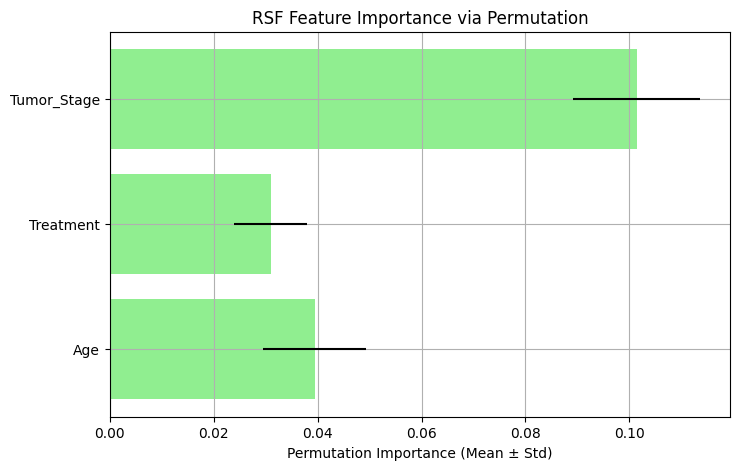

In [25]:
# Visulization of the significance of the features 
# Get feature names
features = ['Age', 'Treatment', 'Tumor_Stage']

# Plot
plt.figure(figsize=(8, 5))
plt.barh(features, result.importances_mean, xerr=result.importances_std, color='lightgreen')
plt.xlabel("Permutation Importance (Mean ± Std)")
plt.title("RSF Feature Importance via Permutation")
plt.grid(True)
plt.show()
